# EDA ML Helper: Predicting Setup Timing Violations in VLSI


#Use machine learning to predict whether a VLSI timing path causes a setup violation based on key circuit parameters.


In [1]:
#  Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import zscore

In [2]:
# For reproducibility
np.random.seed(42)

#  Step 2: Load the Realistic Dataset
data = pd.read_csv("EDA_Timing_Violation.csv")
data.head()

,Delay_ns,Fanout,Path_Length,Logic_Depth,Slack_ns,Setup_Violation
0,3.81,9,13,8,0.05,No
1,6.96,19,15,4,-1.82,Yes
2,5.46,6,63,9,1.56,No
3,5.17,7,29,8,-0.05,Yes
4,2.98,9,39,9,-1.15,Yes


In [3]:
## 🧹 Step 3: Understand & Clean Data
print("Dataset Shape:", data.shape)
print("\nData Types:\n", data.dtypes)
print("\nMissing Values:\n", data.isnull().sum())
print("\nClass Distribution:\n", data['Setup_Violation'].value_counts())


Dataset Shape: (100, 6)

Data Types:
 Delay_ns           float64
Fanout               int64
Path_Length          int64
Logic_Depth          int64
Slack_ns           float64
Setup_Violation     object
dtype: object

Missing Values:
 Delay_ns           0
Fanout             0
Path_Length        0
Logic_Depth        0
Slack_ns           0
Setup_Violation    0
dtype: int64

Class Distribution:
 No     50
Yes    50
Name: Setup_Violation, dtype: int64


In [4]:
# Remove Outliers using Z-Score
numerical_cols = ['Delay_ns', 'Fanout', 'Path_Length', 'Slack_ns']
z_scores = np.abs(zscore(data[numerical_cols]))
data_clean = data[(z_scores < 3).all(axis=1)]
print("\nCleaned Dataset Shape:", data_clean.shape)



Cleaned Dataset Shape: (95, 6)


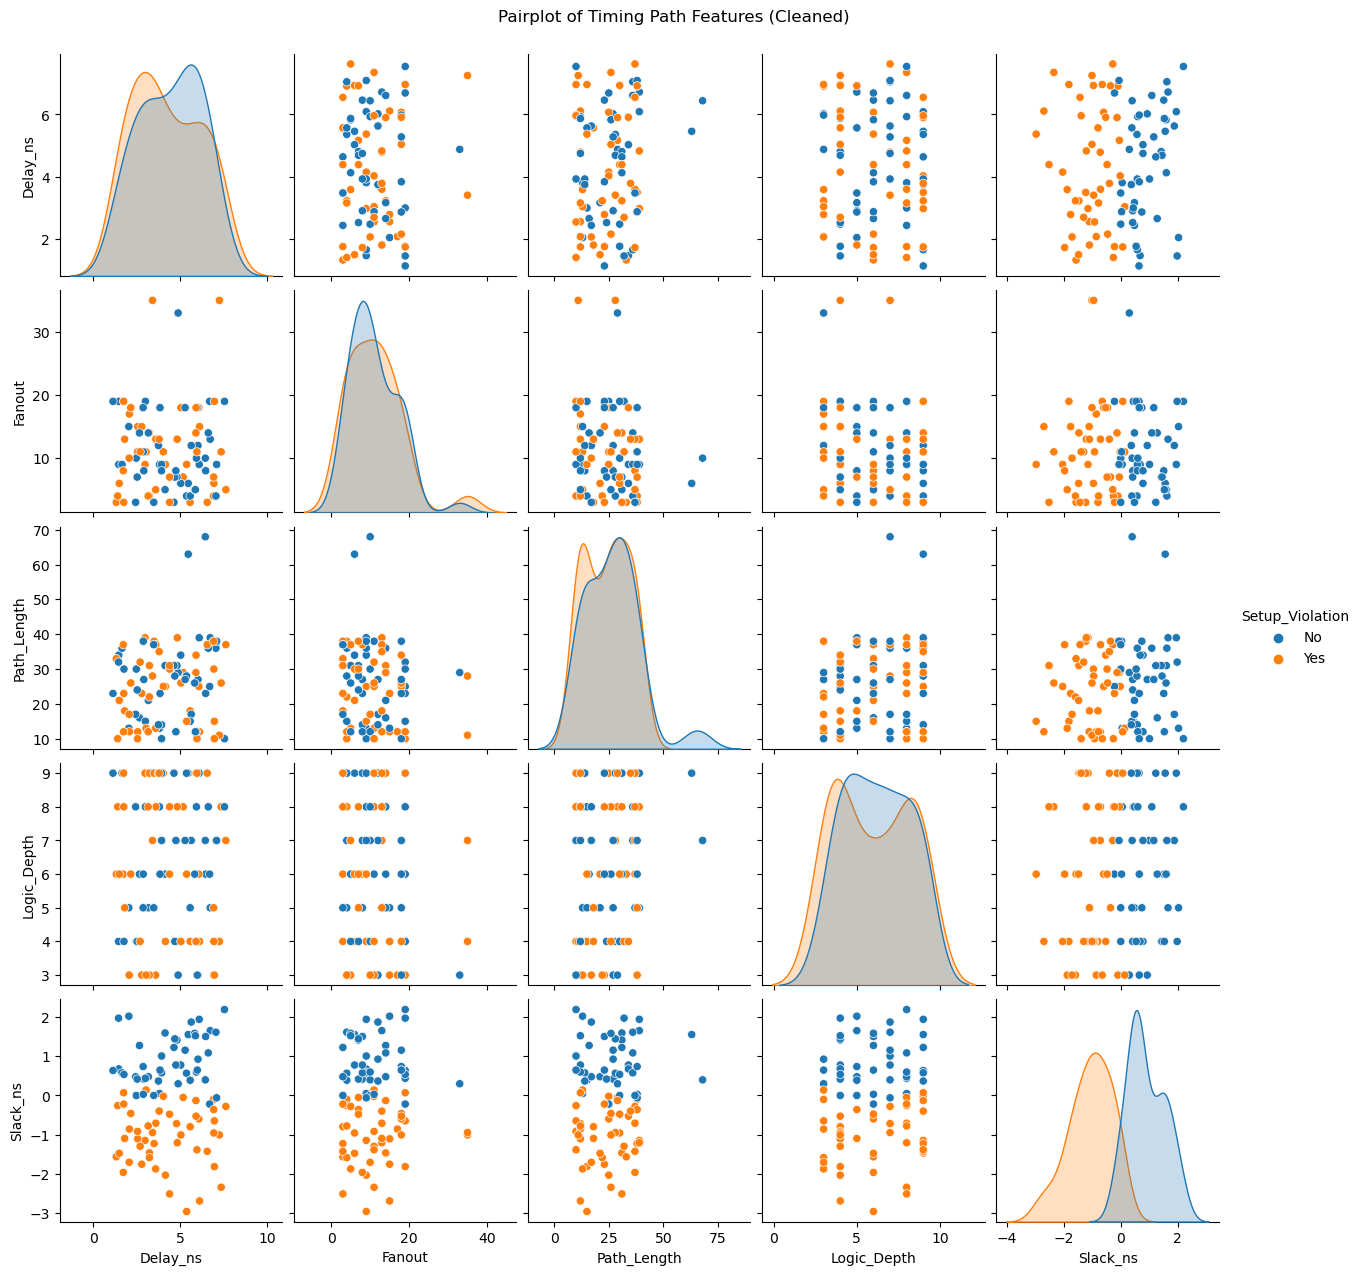

In [5]:
##  Step 4: Exploratory Data Analysis
# Pairplot
sns.pairplot(data_clean, hue="Setup_Violation")
plt.suptitle("Pairplot of Timing Path Features (Cleaned)", y=1.02)
plt.show()

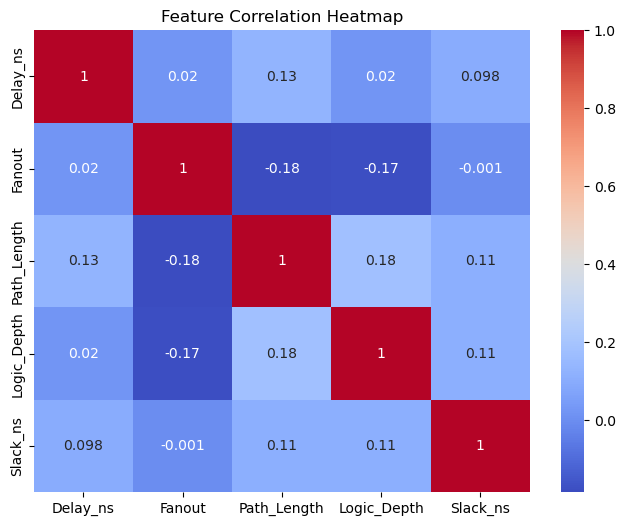

In [6]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data_clean.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [7]:
# Encode Target
data_clean['Setup_Violation'] = data_clean['Setup_Violation'].map({'No': 0, 'Yes': 1})

C:\Users\ABHISHEK BV\AppData\Local\Temp\ipykernel_8224\1190316251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Setup_Violation'] = data_clean['Setup_Violation'].map({'No': 0, 'Yes': 1})


In [8]:
##  Step 5: Model Building
X = data_clean.drop("Setup_Violation", axis=1)
y = data_clean["Setup_Violation"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [9]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)


RandomForestClassifier()

In [10]:
# Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.90      0.95        10

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



In [11]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100)
xgb_model.fit(X_train, y_train)

D:\python\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-09026086f7043a12f-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [12]:
# Predict with XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.90      0.95        10

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



In [13]:
y_pred_xgb = xgb_model.predict(X_test)

In [14]:
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.90      0.95        10

    accuracy                           0.95        19
   macro avg       0.95      0.95      0.95        19
weighted avg       0.95      0.95      0.95        19



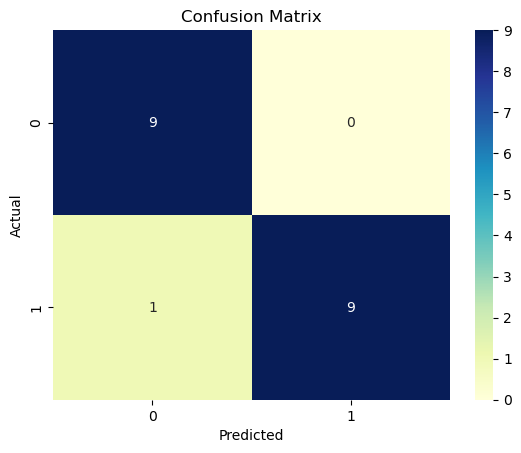

In [15]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

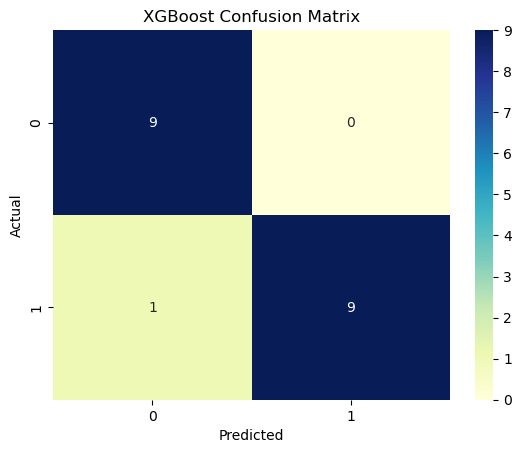

In [16]:
# XGBoost Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap="YlGnBu")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

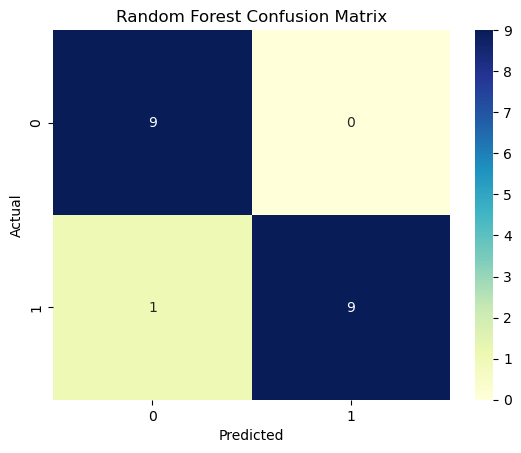

In [17]:
# Random Forest Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="YlGnBu")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

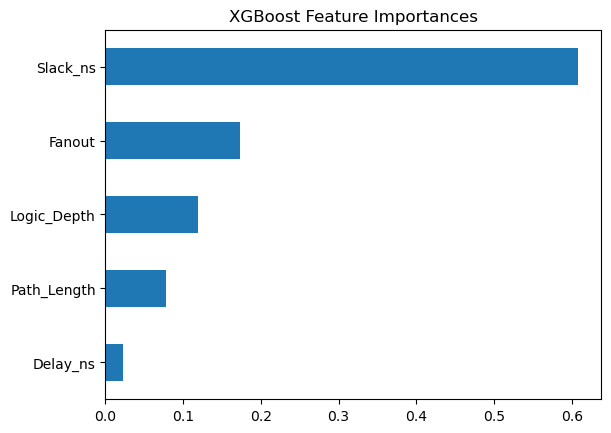

In [18]:
# Feature Importance for XGBoost
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_importances.sort_values().plot(kind='barh')
plt.title("XGBoost Feature Importances")
plt.show()

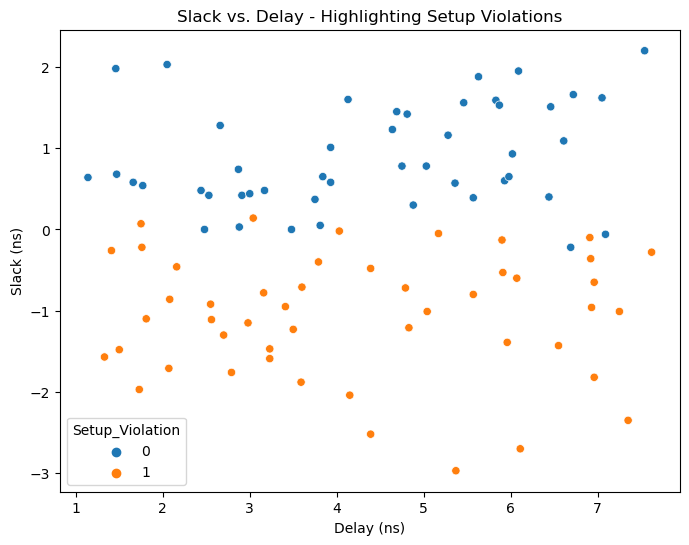

In [19]:
# Slack vs. Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_clean, x="Delay_ns", y="Slack_ns", hue="Setup_Violation")
plt.title("Slack vs. Delay - Highlighting Setup Violations")
plt.xlabel("Delay (ns)")
plt.ylabel("Slack (ns)")
plt.show()


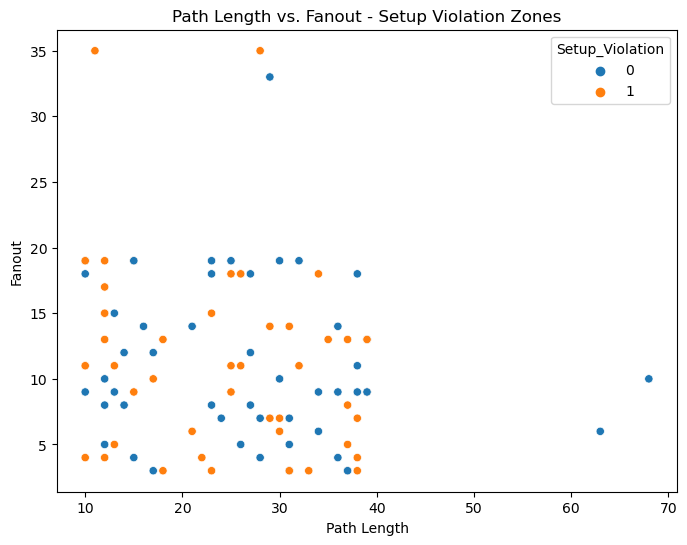

In [20]:
# Path Length vs. Fanout
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data_clean, x="Path_Length", y="Fanout", hue="Setup_Violation")
plt.title("Path Length vs. Fanout - Setup Violation Zones")
plt.xlabel("Path Length")
plt.ylabel("Fanout")
plt.show()


C:\Users\ABHISHEK BV\AppData\Local\Temp\ipykernel_8224\3629235143.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)
D:\python\Lib\site-packages\shap\plots\_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
D:\python\Lib\site-packages\shap\plots\_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

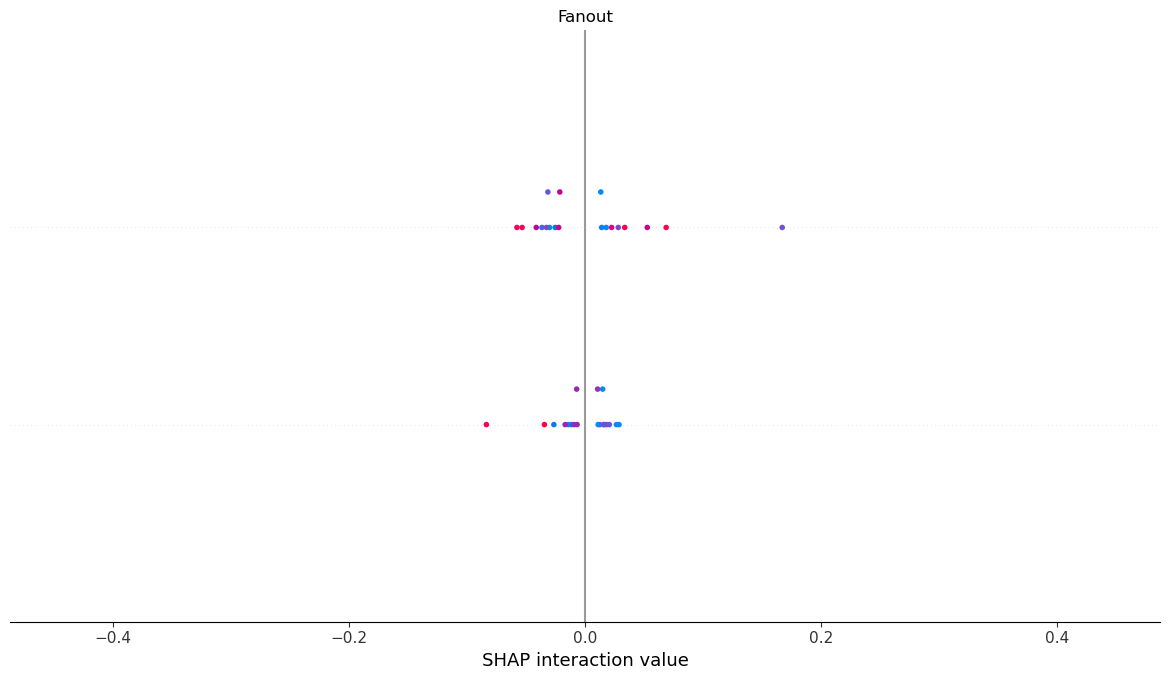

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)



# Conclusion
- Cleaned noisy VLSI timing path data.
- Visualized key relationships like Slack vs. Delay.
- Built a classifier to flag risky paths.
- Used SHAP to explain what drives setup violations.

# This project shows how ML + VLSI design can accelerate circuit optimization & verification!